#  1. 필요 라이브러리 설치

In [1]:
!pip install KoNLPy pyarrow
from google.colab import drive
drive.mount('/content/drive')

from tqdm.auto import tqdm
from datetime import datetime, timedelta
import datetime

from konlpy.tag import Okt, Hannanum
import re

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import re

import torch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 29.4 MB/s eta 0:00:00
Mounted at /content/drive


#2. 원본 데이터 불러오기

  * brand_keyword_cnt_csv : 브랜드별 키워드 검색량

  * product_info_csv : 제품 설명

  * sales_csv : 판매 매출 시계열 데이터셋

  * sample_submission_csv : test 정보

  * train_csv : 판매량 시계열 데이터셋

In [2]:
brand_keyword_cnt_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/final/brand_keyword_cnt.csv')
product_info_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/final/product_info.csv')
sales_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/final/sales.csv')
sample_submission_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/final/sample_submission.csv')
train_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/final/train.csv')

In [88]:
train_csv.shape[0]

28894

#3. 전처리 작업
  * 3.1 제품 설명 전처리 후 product_info_label 생성

## 3.1 제품 설명 전처리 후 product_info_label 생성

  * 불용어 처리

  * Hannanum 형태소 분석기로 명사 추출

  * 길이가 2 이상 7 이하인 단어만 남김

  * Topic Modeling 과정에서 최적 num_topic 수 설정 = 10

  * 토픽 모델링을 통해 product_info_label 부여

  * 이를 product_info_label_csv로 저장(augmentation 데이터셋과의 일원화를 위해)


아래는 사용하지 않을 코드입니다

In [ ]:
# # 불용어처리
# # 한나눔 형태소 분석기 사용
# # 길이 2~7 토큰만 사용

# def tokenize_and_remove_stopwords(text):
#     stop_words = set([
#     "유형", "대상", "횟수", "사용", "방법", "사용방법", "바로", "정", "기능", "함께", "주요","일반", "타입", "유형",
#     "종류", '중량','교체','작동', '균일', '시즌', '증정', "밸런스","패턴", "상태", "가능성", "개인", "개당", "자동", "상관없음",
#     "권장", "구분", "복합", "개선", "전용", "방문", "부가", "이력", "모든", "수량", "출력", "기타", "필수", "해당", "시스템", "수시로", "제품", "품목",
#     "구성","세트", "타입","주요","사용", "적용", "기능","특징", "혜택","조건", "단계", "용도", "과정","타겟",
#     "모드", "관리", "크기", "재질", "편의", "표시", "중심", "모형", "공용", "개월", "세부", "인기", "상품", "효과", "무게", "디테일", "기본", "편리", "인용","정성",
#     "전체", "규격" ])

#     text = re.sub(r'[^가-힣\s]', ' ', text)

#     # 형태소 분석
#     tokens = hannanum.nouns(text)

#     # 불용어 제거
#     token_lst = []
#     for token in tokens:
#         decision = True
#         for stop_word in stop_words:
#             if stop_word in token:
#                 decision = False

#         if decision:
#             if 1 < len(token) < 7 :
#                 token_lst.append(token)
#             elif len(token) >=7 :
#                 token_lst.append(token[:5])

#     if len(token_lst) == 0:
#         return ['불용어처리']
#     else:
#         return token_lst

# hannanum = Hannanum()
# token_df=pd.DataFrame([])
# df = product_info_csv

# token_df['제품특성'] = df['제품특성'].apply(tokenize_and_remove_stopwords)

In [ ]:
# 최적 num_topics를 찾는 과정
# 이미 시행을 통해 10이 좋다는 걸 알았으니 다시 해볼 필요 없음

# # Gensim의 Dictionary 생성
# texts = list(token_df['제품특성'])
# dictionary = Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Coherence와 Perplexity를 계산하여 적정 num_topics를 찾는 함수
# def find_optimal_num_topics(corpus, dictionary, texts, max_topics=20):
#     perplexity_scores = []
#     coherence_scores = []

#     for num_topics in range(2, max_topics + 1):
#         print(f"{num_topics} 토픽 진행 중")
#         lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes = 20, iterations = 20)
#         coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')

#         perplexity_scores.append(lda_model.log_perplexity(corpus))
#         coherence_scores.append(coherence_model.get_coherence())

#     return perplexity_scores, coherence_scores

# # 적정 num_topics를 찾기 위한 계산
# max_topics_to_try = 20
# perplexity_scores, coherence_scores = find_optimal_num_topics(corpus, dictionary, texts, max_topics=max_topics_to_try)

# # Perplexity와 Coherence 점수 출력
# for num_topics, perplexity, coherence in zip(range(2, max_topics_to_try + 1), perplexity_scores, coherence_scores):
#     print(f"Num Topics: {num_topics}, Perplexity: {perplexity:.2f}, Coherence: {coherence:.4f}")

In [ ]:
# # Topic modeling을 통한 product_info_label 생성

# # Gensim의 Dictionary 생성
# texts = list(token_df['제품특성'])
# dictionary = Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # LDA 모델 학습
# num_topics = 10
# lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=20, iterations=20)

# # 문서의 토픽 분포 추출
# lda_top = [lda_model[doc] for doc in corpus]

# # 토픽 및 단어 출력 함수 정의
# def get_topics(lda_model, num_topics, num_words=10):
#     topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
#     for idx, topic in topics:
#         print("Topic %d:" % idx, [(word, prob) for word, prob in topic])

# # 토픽 및 단어 출력
# get_topics(lda_model, num_topics)

# # Coherence score 계산
# coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_score = coherence_model.get_coherence()
# print("Coherence Score:", coherence_score)

Topic 0: [('사이즈', 0.12637183), ('날개형', 0.07820358), ('키즈', 0.063923225), ('성별', 0.06223889), ('샘방지', 0.05443927), ('오줌', 0.051646527), ('팬티형', 0.046930764), ('밴드', 0.0465504), ('매직밴드', 0.04561088), ('대형', 0.041772958)]
Topic 1: [('캡슐', 0.13789444), ('식약처인증', 0.107498325), ('하루', 0.10745064), ('섭취량', 0.107370816), ('성인남녀', 0.089989334), ('식약처고시', 0.04601801), ('원료명', 0.046017982), ('영양소', 0.044148706), ('분말', 0.025161305), ('생균', 0.02461162)]
Topic 2: [('최소연령', 0.16522494), ('포장형태', 0.08214571), ('유발성분', 0.07583964), ('알레르기', 0.06866109), ('신생아', 0.035802387), ('실온보관', 0.028281108), ('젖꼭지', 0.02598629), ('젖병', 0.020578079), ('소독', 0.018839438), ('대두', 0.018037667)]
Topic 3: [('무첨', 0.069545016), ('수분공급', 0.05343195), ('용량', 0.052422635), ('저자극', 0.037967756), ('용기형태', 0.037039995), ('영양공급', 0.036659718), ('모발용', 0.03119274), ('인증', 0.027075114), ('윤기부', 0.021577789), ('모발영양', 0.018516202)]
Topic 4: [('영양소', 0.23395468), ('식약처고시', 0.22721145), ('원료명', 0.22721145), ('비타민', 0.12250714), ('

In [ ]:
# # 0~9까지의 토픽 중에서 각 product_info가 어떤 라벨에 속하는지 지정

# lda_lst = []
# for lda_data in lda_top:
#     highest_prob_topic = max(lda_data, key=lambda x: x[1])[0]
#     lda_lst.append(highest_prob_topic)

# product_info_csv['제품특성 라벨'] = lda_lst

In [ ]:
# product_info_csv.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/product_info.csv", index=False)
# product_info_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/product_info.csv")

In [9]:
# 이는 코드의 정합성을 위하 ad-hoc으로 삽입한 코드이다
product_info_csv['제품특성 라벨'] = 0

[(0, 618), (1, 838), (2, 538), (3, 4718), (4, 1263), (5, 671), (6, 787), (7, 272), (8, 1636), (9, 1437)]


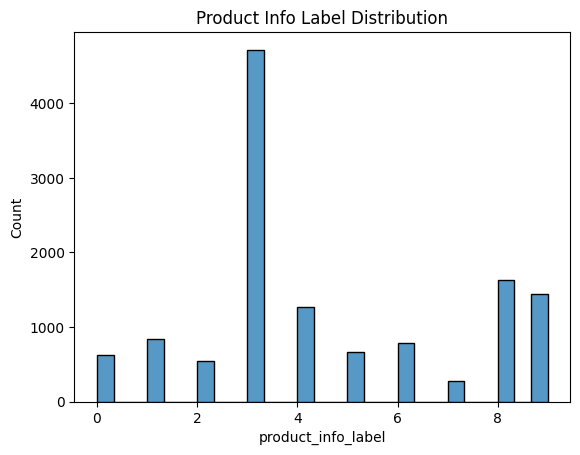

In [ ]:
# print(sorted(Counter(product_info_csv['제품특성 라벨']).items(), key = lambda x:x[0]))
# x = product_info_csv['제품특성 라벨']
# x.name = 'product_info_label'
# sns.histplot(x)
# plt.title("Product Info Label Distribution")
# plt.show()

## 3.2 데이터 1차 전처리
  * brand_keyword_cnt_csv_2 : 3170개의 브랜드에 대한 시계열 데이터가 있던 것을 15890개의 품목에 대한 시계열 데이터로 정리

  * product_info_csv_2 : 3.1에서 생성한 product_info_label을 15890개의 품목에 대한 시계열 데이터로 정리

  * sales_csv_2 : 판매 매출 데이터를 판매량 데이터로 나눠 15890개의 품목에 대한 판매 가격 시계열 데이터로 정리

In [10]:
missing_index_lst = []
for i, x in enumerate(brand_keyword_cnt_csv.isna()['2022-01-01']):
    if x:
        missing_index_lst.append(i)

missing_brand_lst = brand_keyword_cnt_csv.iloc[missing_index_lst]['브랜드']

brand_lst = train_csv['브랜드']

brand_keyword_cnt_csv_2 = pd.DataFrame([])
for brand in tqdm(brand_lst):
    data = brand_keyword_cnt_csv[brand_keyword_cnt_csv['브랜드'] == brand]
    brand_keyword_cnt_csv_2 = pd.concat([brand_keyword_cnt_csv_2, data], ignore_index = True)

# # 3170개 중 35개 데이터가 결측되어 있어서 0으로 채웠다.
brand_keyword_cnt_csv_2 = brand_keyword_cnt_csv_2.fillna(0)

# 추후에 Nan으로 label이 들어간 product_info는 보정을 해줄 것이다.
product_info_csv_2 = pd.DataFrame([])
for index in tqdm(train_csv['제품']):
    feature = product_info_csv[product_info_csv['제품'] == index][['제품특성', '제품특성 라벨']].values
    # feature = product_info_csv[product_info_csv['제품'] == index][['제품특성']].values
    if len(feature) != 0:
        feature = pd.DataFrame(feature, columns = ['feature','product_info_label'])
    else:
        feature = pd.DataFrame([' '], columns=['feature'])
    product_info_csv_2 = pd.concat([product_info_csv_2, feature], ignore_index = True)

  0%|          | 0/28894 [00:00<?, ?it/s]

  0%|          | 0/28894 [00:00<?, ?it/s]

In [11]:
brand_keyword_cnt_csv_2

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,B002-00001,0.84131,0.91383,1.45053,2.42239,1.87119,1.58108,1.23295,1.17493,1.14592,...,0.44966,0.47867,0.60922,0.40615,0.56570,0.34812,0.40615,0.26109,0.29010,0.30461
1,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,8.15201,11.24165,10.00870,9.99419,8.65970,9.74760,8.03597,8.38410,8.57267,10.71946
2,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,8.15201,11.24165,10.00870,9.99419,8.65970,9.74760,8.03597,8.38410,8.57267,10.71946
3,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,8.15201,11.24165,10.00870,9.99419,8.65970,9.74760,8.03597,8.38410,8.57267,10.71946
4,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,8.15201,11.24165,10.00870,9.99419,8.65970,9.74760,8.03597,8.38410,8.57267,10.71946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28889,B002-03798,0.14505,0.00000,0.11604,0.07252,0.11604,0.27560,0.21758,0.11604,0.10153,...,0.15955,0.00000,0.21758,0.10153,0.07252,0.07252,0.11604,0.11604,0.11604,0.18856
28890,B002-03799,4.55468,5.54105,6.15027,6.39686,7.00609,6.65796,5.80214,5.48302,6.03423,...,4.49666,4.32259,5.96170,6.12126,5.57006,5.32346,5.59907,3.37975,4.59820,6.39686
28891,B002-03799,4.55468,5.54105,6.15027,6.39686,7.00609,6.65796,5.80214,5.48302,6.03423,...,4.49666,4.32259,5.96170,6.12126,5.57006,5.32346,5.59907,3.37975,4.59820,6.39686
28892,B002-03799,4.55468,5.54105,6.15027,6.39686,7.00609,6.65796,5.80214,5.48302,6.03423,...,4.49666,4.32259,5.96170,6.12126,5.57006,5.32346,5.59907,3.37975,4.59820,6.39686


In [12]:
product_info_csv_2

,feature,product_info_label
0,헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...,0
1,,NaN
2,,NaN
3,,NaN
4,,NaN
...,...,...
28889,,NaN
28890,,NaN
28891,,NaN
28892,종류:이유식보관용기 특징:전자레인지사용 재질:실리콘 3개세트 LLG508S3,0


In [14]:
train_csv

,ID,제품,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,SAMPLE_00000,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,SAMPLE_00001,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,2,0,2,0,2,2,1,0,0,0
2,SAMPLE_00002,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SAMPLE_00003,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SAMPLE_00004,B002-00002-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00010,0,0,0,...,10,6,4,4,4,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28889,SAMPLE_28889,B002-03798-00046,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28890,SAMPLE_28890,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28891,SAMPLE_28891,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,...,2,4,1,0,0,0,4,0,2,0
28892,SAMPLE_28892,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
sales_csv


,ID,제품,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,SAMPLE_00000,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,SAMPLE_00001,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,44800,0,44800,0,44800,44800,22400,0,0,0
2,SAMPLE_00002,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SAMPLE_00003,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SAMPLE_00004,B002-00002-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00010,0,0,0,...,45740,28360,17320,19200,19200,0,0,0,0,41800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28889,SAMPLE_28889,B002-03798-00046,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28890,SAMPLE_28890,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28891,SAMPLE_28891,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,...,40460,80920,20230,0,0,0,80920,0,40460,0
28892,SAMPLE_28892,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# 판매가격 데이터 형성

drop_columns = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드', '쇼핑몰']
result =(sales_csv.drop(columns =  drop_columns).T / train_csv.drop(columns =  drop_columns).T).fillna(0.)
data_lst = sales_csv.drop(columns =  drop_columns).columns
result = result.T
sales_csv_2= pd.concat([sales_csv[drop_columns], result], axis=1)

In [17]:
sales_csv_2

,ID,제품,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,SAMPLE_00000,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SAMPLE_00001,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0.0,0.0,0.0,...,22400.0,0.000000,22400.0,0.0,22400.0,22400.0,22400.0,0.0,0.0,0.0
2,SAMPLE_00002,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SAMPLE_00003,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SAMPLE_00004,B002-00002-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00010,0.0,0.0,0.0,...,4574.0,4726.666667,4330.0,4800.0,4800.0,0.0,0.0,0.0,0.0,5225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28889,SAMPLE_28889,B002-03798-00046,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,S001-00001,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28890,SAMPLE_28890,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,S001-00001,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28891,SAMPLE_28891,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0.0,0.0,0.0,...,20230.0,20230.000000,20230.0,0.0,0.0,0.0,20230.0,0.0,20230.0,0.0
28892,SAMPLE_28892,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.3 월별 평균 판매량 데이터 만들기

  * 28894 품목에 대해 월별 판매량 평균 데이터를 만든다.

In [18]:
time_lst = []
for i in train_csv.drop(columns = ["ID", '제품', '대분류', '중분류', '소분류', '브랜드', '쇼핑몰']).T.index:
    time_lst.append(i[:-3])

time_result = Counter(time_lst)

In [19]:
time_result

Counter({'2022-01': 31,
         '2022-02': 28,
         '2022-03': 31,
         '2022-04': 30,
         '2022-05': 31,
         '2022-06': 30,
         '2022-07': 31,
         '2022-08': 31,
         '2022-09': 30,
         '2022-10': 31,
         '2022-11': 30,
         '2022-12': 31,
         '2023-01': 31,
         '2023-02': 28,
         '2023-03': 31,
         '2023-04': 24})

In [20]:
# 월별 판매량 평균 데이터, 코드의 정합성을 위해
counter = 0
transpose_train_csv = train_csv.drop(columns = ["ID", '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']).T
average_sales_df = pd.DataFrame()
for time, nums in time_result.items():
    month_data = transpose_train_csv.iloc[counter : counter+ nums].mean()
    month_data = pd.concat([month_data]*nums, axis=1).T
    counter += nums
    average_sales_df = pd.concat([average_sales_df, month_data], axis=0, ignore_index=True)

average_sales_df.index = transpose_train_csv.index
average_month_train_csv = pd.concat([train_csv[["ID", '제품', '대분류', '중분류', '소분류', '브랜드', '쇼핑몰']], average_sales_df.T], axis=1)

In [21]:
average_sales_df

,0,1,2,3,4,5,6,7,8,9,...,28884,28885,28886,28887,28888,28889,28890,28891,28892,28893
2022-01-01,0.0,0.193548,0.0,0.258065,0.000000,0.387097,0.0,23.612903,125.419355,6.451613,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,1.419355,0.000000
2022-01-02,0.0,0.193548,0.0,0.258065,0.000000,0.387097,0.0,23.612903,125.419355,6.451613,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,1.419355,0.000000
2022-01-03,0.0,0.193548,0.0,0.258065,0.000000,0.387097,0.0,23.612903,125.419355,6.451613,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,1.419355,0.000000
2022-01-04,0.0,0.193548,0.0,0.258065,0.000000,0.387097,0.0,23.612903,125.419355,6.451613,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,1.419355,0.000000
2022-01-05,0.0,0.193548,0.0,0.258065,0.000000,0.387097,0.0,23.612903,125.419355,6.451613,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,1.419355,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-20,0.0,1.083333,0.0,0.000000,27.833333,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2.333333,0.25,0.0,0.0,2.25,0.000000,0.583333
2023-04-21,0.0,1.083333,0.0,0.000000,27.833333,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2.333333,0.25,0.0,0.0,2.25,0.000000,0.583333
2023-04-22,0.0,1.083333,0.0,0.000000,27.833333,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2.333333,0.25,0.0,0.0,2.25,0.000000,0.583333
2023-04-23,0.0,1.083333,0.0,0.000000,27.833333,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2.333333,0.25,0.0,0.0,2.25,0.000000,0.583333


### 3.4.1 시간 범주형 데이터 생성

  * train, test 데이터 평일 0, 주말 1

  * train, test 데이터 평일 0, 공휴일 1

  * train, test 데이터 요일 라벨 인코딩

In [40]:
# 훈련 데이터 평일 0, 주말 1

year_month_day_index = train_csv.drop(columns = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']).T.index

start_date = datetime.datetime(int(year_month_day_index[0].split('-')[0]), int(year_month_day_index[0].split('-')[1]), int(year_month_day_index[0].split('-')[2]))
end_date = datetime.datetime(int(year_month_day_index[-1].split('-')[0]), int(year_month_day_index[-1].split('-')[1]), int(year_month_day_index[-1].split('-')[2]))

date_list = []
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
        date_list.append(0)  # 평일
    else:
        date_list.append(1)  # 주말

    current_date += timedelta(days=1)

train_week_weekend_lst = date_list

In [41]:
# 공휴일 칼럼 만드는 함수, 공휴일을 모두 넣어놓아야 합니다.
def is_public_holiday(date):
    kor_holidays = [
            (2022, 1, 1),
            (2022, 1, 31),
            (2022, 2, 1),
            (2022, 2, 2),
            (2022, 3, 1),
            (2022, 3, 9),
            (2022, 5, 5),
            (2022, 5, 8),
            (2022, 6, 1),
            (2022, 6, 6),
            (2022, 8, 15),
            (2022, 9, 9),
            (2022, 9, 10),
            (2022, 9, 11),
            (2022, 9, 12),
            (2022, 10, 3),
            (2022, 10, 9),
            (2022, 10, 10),
            (2022, 12, 25),
            (2022, 12, 31),
            (2023, 1, 1),
            (2023, 1, 21),
            (2023, 1, 22),
            (2023, 1, 23),
            (2023, 1, 24),
            (2023, 3, 1),
            (2023, 5, 5),
            (2023, 5, 27),
            (2023, 6, 6),
            (2023, 8, 15),
            (2023, 9, 28),
            (2023, 9, 29),
            (2023, 9, 30),
            (2023, 10, 3),
            (2023, 10, 9),
            (2023, 12, 25),
            (2023, 12, 31)]

    return (date.year, date.month, date.day) in kor_holidays

In [42]:
# 훈련 데이터 평일 0 공휴일 1

year_month_day_index = train_csv.drop(columns = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드', '쇼핑몰']).T.index
start_date = datetime.datetime(int(year_month_day_index[0].split('-')[0]), int(year_month_day_index[0].split('-')[1]), int(year_month_day_index[0].split('-')[2]))
end_date = datetime.datetime(int(year_month_day_index[-1].split('-')[0]), int(year_month_day_index[-1].split('-')[1]), int(year_month_day_index[-1].split('-')[2]))

train_special_days = []
current_date = start_date

while current_date <= end_date:
    if is_public_holiday(current_date):
        train_special_days.append(1)
    else:
        train_special_days.append(0)

    current_date += timedelta(days=1)

In [43]:
# test 데이터 평일 0 주말 1
year_month_day_index = sample_submission_csv.drop(columns = ['ID']).T.index

start_date = datetime.datetime(int(year_month_day_index[0].split('-')[0]), int(year_month_day_index[0].split('-')[1]), int(year_month_day_index[0].split('-')[2]))
end_date = datetime.datetime(int(year_month_day_index[-1].split('-')[0]), int(year_month_day_index[-1].split('-')[1]), int(year_month_day_index[-1].split('-')[2]))

date_list = []
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
        date_list.append(0)  # 평일
    else:
        date_list.append(1)  # 주말

    current_date += timedelta(days=1)

test_week_weekend_lst = date_list

In [28]:
# test 데이터 평일 0 공휴일 1
year_month_day_index = sample_submission_csv.drop(columns = ['ID']).T.index
start_date = datetime.datetime(int(year_month_day_index[0].split('-')[0]), int(year_month_day_index[0].split('-')[1]), int(year_month_day_index[0].split('-')[2]))
end_date = datetime.datetime(int(year_month_day_index[-1].split('-')[0]), int(year_month_day_index[-1].split('-')[1]), int(year_month_day_index[-1].split('-')[2]))

test_special_days = []
current_date = start_date

while current_date <= end_date:
    if is_public_holiday(current_date):
        test_special_days.append(1)
    else:
        test_special_days.append(0)

    current_date += timedelta(days=1)

In [29]:
# train 데이터 요일 라벨 인코딩
year_month_day_index = train_csv.drop(columns = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드', '쇼핑몰']).T.index
start_date = datetime.date(int(year_month_day_index[0].split('-')[0]), int(year_month_day_index[0].split('-')[1]), int(year_month_day_index[0].split('-')[2]))
end_date = datetime.date(int(year_month_day_index[-1].split('-')[0]), int(year_month_day_index[-1].split('-')[1]), int(year_month_day_index[-1].split('-')[2]))

day_of_week_mapping = {
    0: "월요일",
    1: "화요일",
    2: "수요일",
    3: "목요일",
    4: "금요일",
    5: "토요일",
    6: "일요일"
}

# 날짜 순회하며 요일 라벨 인코딩
current_date = start_date
train_day = []
while current_date <= end_date:
    day_of_week = current_date.weekday()  # 요일을 0(월요일)부터 6(일요일)까지 숫자로 표현
    label_encoded_day = day_of_week  # 직접 숫자로 라벨 인코딩
    day_name = day_of_week_mapping[day_of_week]
    train_day.append(label_encoded_day)
    # print(f"{current_date}: {day_name} ({label_encoded_day})")
    current_date += datetime.timedelta(days=1)

In [30]:
# test 데이터 요일 라벨 인코딩
year_month_day_index = sample_submission_csv.drop(columns = ['ID']).T.index
start_date = datetime.date(int(year_month_day_index[0].split('-')[0]), int(year_month_day_index[0].split('-')[1]), int(year_month_day_index[0].split('-')[2]))
end_date = datetime.date(int(year_month_day_index[-1].split('-')[0]), int(year_month_day_index[-1].split('-')[1]), int(year_month_day_index[-1].split('-')[2]))

day_of_week_mapping = {
    0: "월요일",
    1: "화요일",
    2: "수요일",
    3: "목요일",
    4: "금요일",
    5: "토요일",
    6: "일요일"
}

# 날짜 순회하며 요일 라벨 인코딩
current_date = start_date
test_day = []
while current_date <= end_date:
    day_of_week = current_date.weekday()  # 요일을 0(월요일)부터 6(일요일)까지 숫자로 표현
    label_encoded_day = day_of_week  # 직접 숫자로 라벨 인코딩
    test_day.append(label_encoded_day)
    day_name = day_of_week_mapping[day_of_week]
    print(f"{current_date}: {day_name} ({label_encoded_day})")
    current_date += datetime.timedelta(days=1)

2023-04-25: 화요일 (1)
2023-04-26: 수요일 (2)
2023-04-27: 목요일 (3)
2023-04-28: 금요일 (4)
2023-04-29: 토요일 (5)
2023-04-30: 일요일 (6)
2023-05-01: 월요일 (0)
2023-05-02: 화요일 (1)
2023-05-03: 수요일 (2)
2023-05-04: 목요일 (3)
2023-05-05: 금요일 (4)
2023-05-06: 토요일 (5)
2023-05-07: 일요일 (6)
2023-05-08: 월요일 (0)
2023-05-09: 화요일 (1)
2023-05-10: 수요일 (2)
2023-05-11: 목요일 (3)
2023-05-12: 금요일 (4)
2023-05-13: 토요일 (5)
2023-05-14: 일요일 (6)
2023-05-15: 월요일 (0)


### 3.4.2 시간 실수형 데이터 생성
  * 추후 합본에서 만들도록 한다



## 3.5 이동 평균, 지수평활, 잔차

  * train_moving_avg_csv : 이동 평균 window = 30

  * train_ewm_csv : 지수 평활 alpha = 0.2

  * train_diff_csv : 잔차

In [32]:
def calculate_moving_average(data, window_size):

    moving_average = data.rolling(window=window_size).mean()
    return moving_average

def exponential_smoothing(data, alpha):

    smoothed = data.ewm(alpha=alpha, adjust=False).mean()
    return smoothed

window_size = 30
alpha = 0.2

train_diff_csv = pd.concat([train_csv[['ID', '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']], train_csv.drop(columns = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']).T.diff().fillna(0.).T], axis=1)
train_moving_avg_csv = pd.concat([train_csv[['ID', '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']], train_csv.drop(columns = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']).T.rolling(window = window_size).mean().fillna(0.).T], axis=1)
train_ewm_csv = pd.concat([train_csv[['ID', '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']], train_csv.drop(columns = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']).T.ewm(alpha = alpha, adjust=False).mean().fillna(0.).T], axis=1)

## 3.6 product_info_label 결측치 처리

  * 소분류가 같은 품목 중 가장 많은 수의 product_info_label을 차지하는 것을 임의 부여

In [36]:
def label_prediction(sub_series, label_series):
    label_lst = []
    for i, (label, sub) in enumerate(zip(label_series, sub_series)):
        if type(label) == type(np.NaN):
            label_index = list(label_series[sub_series[sub_series == sub].index].value_counts().index)

            try :
                label_index.remove(np.NaN)
            except :
                pass

            label = label_index[0]


        label_lst.append(label)
    return label_lst

label_lst = label_prediction(train_csv['소분류'], product_info_csv_2['product_info_label'])
product_info_csv_2['product_info_label'] = label_lst

In [37]:
product_info_csv_2

,feature,product_info_label
0,헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...,0
1,,0
2,,0
3,,0
4,,0
...,...,...
28889,,0
28890,,0
28891,,0
28892,종류:이유식보관용기 특징:전자레인지사용 재질:실리콘 3개세트 LLG508S3,0


# 4. 합본 만들기

In [53]:
length = product_info_csv_2.shape[0]
train_df = pd.DataFrame([])
year_month_day_index = train_csv.drop(columns = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰']).T.index
for i,time_index in enumerate(tqdm(year_month_day_index)):

    train = train_csv[['제품', '대분류', '중분류', '소분류', '브랜드','쇼핑몰', time_index]]
    train.columns = ['product', 'major', 'middle', 'sub', 'brand', 'shop', 'sales_rate']

    diff_train = pd.DataFrame(train_diff_csv[time_index])
    diff_train.columns = ['diff_sales']

    moving_avg_train = pd.DataFrame(train_moving_avg_csv[time_index])
    moving_avg_train.columns = ['moving_avg_sales']

    ewm_train = pd.DataFrame(train_ewm_csv[time_index])
    ewm_train.columns = ['ewm_sales']

    time_ = pd.DataFrame([str(time_index)] * len(train))
    time_.columns = ['time']

    train_nums = pd.DataFrame(range(0, length))
    train_nums.columns = ['product_nums']

    month = pd.DataFrame([(time_index.split('-')[1])] * len(train))
    month.columns = ['month']

    time_idx = pd.DataFrame([i] * len(train))
    time_idx.columns = ['time_idx']

    # sales = pd.DataFrame(sales_csv[time_index])
    # sales.columns = ['sales']
    sales = pd.DataFrame(sales_csv_2[time_index])
    sales.columns = ['sales']

    average_month_sales_rate = pd.DataFrame(average_month_train_csv[time_index])
    average_month_sales_rate.columns = ['average_month_sales_rate']

    brand_keyword_cnt = pd.DataFrame(brand_keyword_cnt_csv_2[time_index])
    brand_keyword_cnt.columns = ['keyword_cnt']

    product_info = pd.DataFrame(product_info_csv_2[['feature','product_info_label']])
    product_info.columns = ['product_info','product_info_label']

    week_weekend = pd.DataFrame([train_week_weekend_lst[i]]* len(train))
    week_weekend.columns = ['week_weekend']

    special_day = pd.DataFrame( [train_special_days[i]]* len(train))
    special_day.columns = ['special_day']

    train_day_ = pd.DataFrame( [train_day[i]]* len(train))
    train_day_.columns = ['day']

    result_df = pd.concat([time_, month, time_idx, week_weekend, train_day_, special_day, train_nums, train, diff_train, moving_avg_train, ewm_train, average_month_sales_rate, sales, brand_keyword_cnt, product_info], axis = 1)
    train_df = pd.concat([train_df, result_df], ignore_index=True, axis = 0)

  0%|          | 0/479 [00:00<?, ?it/s]

In [54]:
test_df = pd.DataFrame([])
year_month_day_index = sample_submission_csv.drop(columns = ['ID']).T.index
for i,time_index in enumerate(tqdm(year_month_day_index)):

    test = train_csv[['제품', '대분류', '중분류', '소분류', '브랜드', '쇼핑몰']]
    test.columns = ['product', 'major', 'middle', 'sub', 'brand', 'shop']

    sales_rate = pd.DataFrame([0.] * len(test))
    sales_rate.columns = ['sales_rate']

    diff_test = pd.DataFrame([0.] * len(test))
    diff_test.columns = ['diff_sales']

    moving_avg_test = pd.DataFrame([0.] * len(test))
    moving_avg_test.columns = ['moving_avg_sales']

    ewm_test = pd.DataFrame([0.] * len(test))
    ewm_test.columns = ['ewm_sales']

    time_ = pd.DataFrame([str(time_index)] * len(test))
    time_.columns = ['time']

    test_nums = pd.DataFrame(range(0, length))
    test_nums.columns = ['product_nums']

    month = pd.DataFrame([(time_index.split('-')[1])] * len(test))
    month.columns = ['month']

    time_idx = pd.DataFrame([459 + i] * len(test))
    time_idx.columns = ['time_idx']

    # sales = pd.DataFrame(sales_csv[time_index])
    # sales.columns = ['sales']
    sales = pd.DataFrame([0.] * len(test))
    sales.columns = ['sales']

    average_month_sales_rate = pd.DataFrame([0.] * len(test))
    average_month_sales_rate.columns = ['average_month_sales_rate']

    brand_keyword_cnt = pd.DataFrame([0.] * len(test))
    brand_keyword_cnt.columns = ['keyword_cnt']

    product_info = pd.DataFrame(product_info_csv_2[['feature','product_info_label']])
    product_info.columns = ['product_info','product_info_label']

    week_weekend = pd.DataFrame( [test_week_weekend_lst[i]]* len(test))
    week_weekend.columns = ['week_weekend']

    special_day = pd.DataFrame( [test_special_days[i]]* len(test))
    special_day.columns = ['special_day']

    test_day_ = pd.DataFrame( [test_day[i]]* len(test))
    test_day_.columns = ['day']

    result_df = pd.concat([time_, month, time_idx, week_weekend, test_day_, special_day,test_nums, test, sales_rate, diff_test, moving_avg_test,  ewm_test, average_month_sales_rate, sales, brand_keyword_cnt, product_info], axis = 1)
    test_df = pd.concat([test_df, result_df], ignore_index=True, axis = 0)

  0%|          | 0/21 [00:00<?, ?it/s]

In [55]:
train_df.shape

(13840226, 22)

# 합본 이후 feature

In [10]:
train_df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Data/final/preprocessed_train_7.parquet')
test_df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data/final/preprocessed_test_7.parquet")

In [11]:
train_df.head()

,time,month,time_idx,week_weekend,day,special_day,product_nums,product,major,middle,...,product_info,product_info_label,sales_rate_log,date_cos,date_sin,day_cos,day_sin,month_cos,month_sin,weight
0,2022-01-01,01,0,1,5,1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,...,헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...,4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.296359
1,2022-01-01,01,0,1,5,1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,...,,4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695
2,2022-01-01,01,0,1,5,1,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,...,,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695
3,2022-01-01,01,0,1,5,1,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,...,,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695
4,2022-01-01,01,0,1,5,1,4,B002-00002-00004,B002-C001-0003,B002-C002-0008,...,,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695


## log_scaling 판매량

In [56]:
# log-scaling 추가가 안 되어서 여기서 넣도록 한다.
def log_scaling(x, scale_factor=1.0):
    return np.log(x * scale_factor + 1)

sales_rate_log = log_scaling(train_df['sales_rate'])
train_df['sales_rate_log'] = sales_rate_log
test_df['sales_rate_log'] = 0.

## 시간 실수형 데이터 생성

In [58]:
import math

train_time_idx = train_df['time_idx'].astype(int)
date = (train_time_idx / 182.5) * math.pi
day = (train_time_idx / 3.5) * math.pi
month = (train_time_idx / 30.5) * math.pi

date_cos = date.apply(lambda x: math.cos(x))
date_sine = date.apply(lambda x: math.sin(x))

day_cos =  date.apply(lambda x: math.cos(x))
day_sine =  date.apply(lambda x: math.sin(x))

month_cos =  date.apply(lambda x: math.cos(x))
month_sine =  date.apply(lambda x: math.sin(x))

train_df['date_cos'] = date_cos
train_df['date_sin'] = date_sine
train_df['day_cos'] = day_cos
train_df['day_sin'] = day_sine
train_df['month_cos'] = month_cos
train_df['month_sin'] = month_sine

test_time_idx = test_df['time_idx'].astype(int)
date = (test_time_idx / 182.5) * math.pi
day = (test_time_idx / 3.5) * math.pi
month = (test_time_idx / 30.5) * math.pi

date_cos = date.apply(lambda x: math.cos(x))
date_sine = date.apply(lambda x: math.sin(x))

day_cos =  date.apply(lambda x: math.cos(x))
day_sine =  date.apply(lambda x: math.sin(x))

month_cos =  date.apply(lambda x: math.cos(x))
month_sine =  date.apply(lambda x: math.sin(x))

test_df['date_cos'] = date_cos
test_df['date_sin'] = date_sine
test_df['day_cos'] = day_cos
test_df['day_sin'] = day_sine
test_df['month_cos'] = month_cos
test_df['month_sin'] = month_sine

## 월별 판매량 평균 수정 코드

In [59]:
train_df.head()

,time,month,time_idx,week_weekend,day,special_day,product_nums,product,major,middle,...,keyword_cnt,product_info,product_info_label,sales_rate_log,date_cos,date_sin,day_cos,day_sin,month_cos,month_sin
0,2022-01-01,01,0,1,5,1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,...,0.84131,헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2022-01-01,01,0,1,5,1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,...,12.64868,,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2022-01-01,01,0,1,5,1,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,...,12.64868,,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,2022-01-01,01,0,1,5,1,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,...,12.64868,,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,2022-01-01,01,0,1,5,1,4,B002-00002-00004,B002-C001-0003,B002-C002-0008,...,12.64868,,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [60]:
total_length = train_df.shape[0]
total_result = pd.Series([])

for num, data in tqdm(train_df[['sales_rate','product_nums']].groupby(['product_nums'])):

    index = data.index
    length = data['sales_rate'].shape[0]
    start_positions = list(range(length))
    result = []
    for start_position in start_positions:
        if start_position == 0:
            x = data['sales_rate'].iloc[start_position]

        elif start_position <= 29:
            x = data['sales_rate'].iloc[ : start_position].mean()

        elif start_position >= 30:
            x = data['sales_rate'].iloc[start_position-30 : start_position].mean()

        result.append(x)

    result = pd.Series(result)
    result.index =  index
    total_result = pd.concat([total_result, result])

total_result = total_result.reindex(list(range(total_length)))

<ipython-input-60-fb69b69db211>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  total_result = pd.Series([])
/usr/local/lib/python3.10/dist-packages/tqdm/asyncio.py:33: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  self.iterable_iterator = iter(iterable)


  0%|          | 0/28894 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/tqdm/std.py:1182: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:


In [61]:
train_df['average_month_sales_rate'] = total_result

## weight 생성

In [62]:
data_target = train_df.iloc[:28894]
total = data_target.shape[0]
weight_dict = {}
for major, num in sorted(Counter(data_target['major'].apply(lambda x: int(x[-1:]))).items(), key=lambda x: x[0]):
    weight_dict[major] = 1 - (num / total)

train_df['weight'] = train_df['major'].apply(lambda x: int(x[-1:])).map(weight_dict)
test_df['weight'] = test_df['major'].apply(lambda x: int(x[-1:])).map(weight_dict)

In [4]:
# 여기선 서환님의 파일을 받아서 가져올 계획이다.
combined_data_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ysh/combined_data_2.csv')

In [5]:
train_df['product_info_label'] = list(combined_data_csv['label']) * 479
test_df['product_info_label'] = list(combined_data_csv['label']) * 21

In [12]:
combined_data_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ysh/combined_data_3.csv')

In [15]:
train_df['baby'] = list(combined_data_csv['baby']) * 479
test_df['baby'] = list(combined_data_csv['baby']) * 21

In [16]:
train_df.head()

,time,month,time_idx,week_weekend,day,special_day,product_nums,product,major,middle,...,product_info_label,sales_rate_log,date_cos,date_sin,day_cos,day_sin,month_cos,month_sin,weight,baby
0,2022-01-01,01,0,1,5,1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,...,4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.296359,0
1,2022-01-01,01,0,1,5,1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,...,4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695,0
2,2022-01-01,01,0,1,5,1,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,...,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695,0
3,2022-01-01,01,0,1,5,1,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,...,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695,0
4,2022-01-01,01,0,1,5,1,4,B002-00002-00004,B002-C001-0003,B002-C002-0008,...,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695,0


In [63]:
train_df['month'] = train_df['month'].astype(str)
train_df['time_idx'] = train_df['time_idx'].astype(int)
train_df['sales_rate'] = train_df['sales_rate'].astype(float)
train_df['week_weekend'] = train_df['week_weekend'].astype(str)
train_df['special_day'] = train_df['special_day'].astype(str)
train_df['product_info_label'] = train_df['product_info_label'].astype(str)
train_df['day'] = train_df['day'].astype(str)

test_df['month'] = test_df['month'].astype(str)
test_df['time_idx'] = test_df['time_idx'].astype(int)
test_df['sales_rate'] = test_df['sales_rate'].astype(float)
test_df['week_weekend'] = test_df['week_weekend'].astype(str)
test_df['special_day'] = test_df['special_day'].astype(str)
test_df['product_info_label'] = test_df['product_info_label'].astype(str)
test_df['day'] = test_df['day'].astype(str)

In [64]:
train_df.head()

,time,month,time_idx,week_weekend,day,special_day,product_nums,product,major,middle,...,product_info,product_info_label,sales_rate_log,date_cos,date_sin,day_cos,day_sin,month_cos,month_sin,weight
0,2022-01-01,01,0,1,5,1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,...,헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.296359
1,2022-01-01,01,0,1,5,1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,...,,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695
2,2022-01-01,01,0,1,5,1,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,...,,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695
3,2022-01-01,01,0,1,5,1,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,...,,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695
4,2022-01-01,01,0,1,5,1,4,B002-00002-00004,B002-C001-0003,B002-C002-0008,...,,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.982695


## test_df의 keyword_cnt 수정

In [65]:
keyword_cnt = train_df['keyword_cnt'].iloc[:28894]
keyword_cnt = pd.Series(list(keyword_cnt) * int(test_df.shape[0] / 28894))

In [66]:
test_df['keyword_cnt'] = keyword_cnt

In [67]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840226 entries, 0 to 13840225
Data columns (total 30 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   time                      object 
 1   month                     object 
 2   time_idx                  int64  
 3   week_weekend              object 
 4   day                       object 
 5   special_day               object 
 6   product_nums              int64  
 7   product                   object 
 8   major                     object 
 9   middle                    object 
 10  sub                       object 
 11  brand                     object 
 12  shop                      object 
 13  sales_rate                float64
 14  diff_sales                float64
 15  moving_avg_sales          float64
 16  ewm_sales                 float64
 17  average_month_sales_rate  float64
 18  sales                     float64
 19  keyword_cnt               float64
 20  product_info          

In [68]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606774 entries, 0 to 606773
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   time                      606774 non-null  object 
 1   month                     606774 non-null  object 
 2   time_idx                  606774 non-null  int64  
 3   week_weekend              606774 non-null  object 
 4   day                       606774 non-null  object 
 5   special_day               606774 non-null  object 
 6   product_nums              606774 non-null  int64  
 7   product                   606774 non-null  object 
 8   major                     606774 non-null  object 
 9   middle                    606774 non-null  object 
 10  sub                       606774 non-null  object 
 11  brand                     606774 non-null  object 
 12  shop                      606774 non-null  object 
 13  sales_rate                606774 non-null  f

In [ ]:
train_df['product_info_label']

0            2
1            4
2            3
3            4
4            1
          ... 
7293505    232
7293506    232
7293507    230
7293508    231
7293509    231
Name: product_info_label, Length: 7293510, dtype: object

In [69]:
test_df

,time,month,time_idx,week_weekend,day,special_day,product_nums,product,major,middle,...,product_info,product_info_label,sales_rate_log,date_cos,date_sin,day_cos,day_sin,month_cos,month_sin,weight
0,2023-04-25,04,459,0,1,0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,...,헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...,0,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.296359
1,2023-04-25,04,459,0,1,0,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.982695
2,2023-04-25,04,459,0,1,0,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.982695
3,2023-04-25,04,459,0,1,0,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.982695
4,2023-04-25,04,459,0,1,0,4,B002-00002-00004,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.982695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606769,2023-05-15,05,479,0,0,0,28889,B002-03798-00046,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.381689,0.924291,-0.381689,0.924291,-0.381689,0.924291,0.982695
606770,2023-05-15,05,479,0,0,0,28890,B002-03799-00002,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.381689,0.924291,-0.381689,0.924291,-0.381689,0.924291,0.982695
606771,2023-05-15,05,479,0,0,0,28891,B002-03799-00003,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.381689,0.924291,-0.381689,0.924291,-0.381689,0.924291,0.982695
606772,2023-05-15,05,479,0,0,0,28892,B002-03799-00004,B002-C001-0003,B002-C002-0008,...,종류:이유식보관용기 특징:전자레인지사용 재질:실리콘 3개세트 LLG508S3,0,0.0,-0.381689,0.924291,-0.381689,0.924291,-0.381689,0.924291,0.982695


In [70]:
train_df

,time,month,time_idx,week_weekend,day,special_day,product_nums,product,major,middle,...,product_info,product_info_label,sales_rate_log,date_cos,date_sin,day_cos,day_sin,month_cos,month_sin,weight
0,2022-01-01,01,0,1,5,1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,...,헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...,0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.296359
1,2022-01-01,01,0,1,5,1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,...,,0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.982695
2,2022-01-01,01,0,1,5,1,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,...,,0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.982695
3,2022-01-01,01,0,1,5,1,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,...,,0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.982695
4,2022-01-01,01,0,1,5,1,4,B002-00002-00004,B002-C001-0003,B002-C002-0008,...,,0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.982695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13840221,2023-04-24,04,478,0,0,0,28889,B002-03798-00046,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.365723,0.930724,-0.365723,0.930724,-0.365723,0.930724,0.982695
13840222,2023-04-24,04,478,0,0,0,28890,B002-03799-00002,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.365723,0.930724,-0.365723,0.930724,-0.365723,0.930724,0.982695
13840223,2023-04-24,04,478,0,0,0,28891,B002-03799-00003,B002-C001-0003,B002-C002-0008,...,,0,0.0,-0.365723,0.930724,-0.365723,0.930724,-0.365723,0.930724,0.982695
13840224,2023-04-24,04,478,0,0,0,28892,B002-03799-00004,B002-C001-0003,B002-C002-0008,...,종류:이유식보관용기 특징:전자레인지사용 재질:실리콘 3개세트 LLG508S3,0,0.0,-0.365723,0.930724,-0.365723,0.930724,-0.365723,0.930724,0.982695


# 저장 및 불러오기

In [17]:
# train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/preprocessed_train_7.csv')
# test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/preprocessed_test_7.csv")
train_df.to_parquet('/content/drive/MyDrive/Colab Notebooks/Data/final/preprocessed_train_7.parquet')
test_df.to_parquet('/content/drive/MyDrive/Colab Notebooks/Data/final/preprocessed_test_7.parquet')

In [ ]:
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/preprocessed_train_7.csv')
# test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/preprocessed_test_7.csv")

In [9]:
test_df

,time,month,time_idx,week_weekend,day,special_day,product_nums,product,major,middle,...,product_info,product_info_label,sales_rate_log,date_cos,date_sin,day_cos,day_sin,month_cos,month_sin,weight
0,2023-04-25,04,459,0,1,0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,...,헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...,4,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.296359
1,2023-04-25,04,459,0,1,0,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,...,,4,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.982695
2,2023-04-25,04,459,0,1,0,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,...,,1,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.982695
3,2023-04-25,04,459,0,1,0,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,...,,2,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.982695
4,2023-04-25,04,459,0,1,0,4,B002-00002-00004,B002-C001-0003,B002-C002-0008,...,,2,0.0,-0.047321,0.998880,-0.047321,0.998880,-0.047321,0.998880,0.982695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606769,2023-05-15,05,479,0,0,0,28889,B002-03798-00046,B002-C001-0003,B002-C002-0008,...,,276,0.0,-0.381689,0.924291,-0.381689,0.924291,-0.381689,0.924291,0.982695
606770,2023-05-15,05,479,0,0,0,28890,B002-03799-00002,B002-C001-0003,B002-C002-0008,...,,276,0.0,-0.381689,0.924291,-0.381689,0.924291,-0.381689,0.924291,0.982695
606771,2023-05-15,05,479,0,0,0,28891,B002-03799-00003,B002-C001-0003,B002-C002-0008,...,,276,0.0,-0.381689,0.924291,-0.381689,0.924291,-0.381689,0.924291,0.982695
606772,2023-05-15,05,479,0,0,0,28892,B002-03799-00004,B002-C001-0003,B002-C002-0008,...,종류:이유식보관용기 특징:전자레인지사용 재질:실리콘 3개세트 LLG508S3,272,0.0,-0.381689,0.924291,-0.381689,0.924291,-0.381689,0.924291,0.982695


In [73]:
train_df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Data/final/preprocessed_train_7.parquet')
test_df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data/final/preprocessed_test_7.parquet")

In [77]:
train_df['shop']

0           S001-00001
1           S001-00001
2           S001-00001
3           S001-00001
4           S001-00010
               ...    
13840221    S001-00001
13840222    S001-00001
13840223    S001-00001
13840224    S001-00001
13840225    S001-00001
Name: shop, Length: 13840226, dtype: object

In [76]:
test_df['keyword_cnt']

0          0.84131
1         12.64868
2         12.64868
3         12.64868
4         12.64868
            ...   
606769     0.14505
606770     4.55468
606771     4.55468
606772     4.55468
606773     4.55468
Name: keyword_cnt, Length: 606774, dtype: float64